<a href="https://colab.research.google.com/drive/1ghhsuMFm0I9mECEHbyPw84P2Fm6yvZvz?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Machine Learning - MVP Sistemas Inteligentes
### Modelo de Classificação TEA

Este modelo visa classificar se uma pessoa ADULTA está no espectro autista ou não com base no AQ Score (Autism-Spectrum Quotient Score) e outras informações relevantes que podem influenciar no resultado do teste.

## Configuração do ambiente

In [1]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

## Carga do Dataset

O dataset contém informações sobre vários pacientes, com cada registro representando uma pessoa. As variáveis incluem resultados do Teste AQ Score, que possui Features de 1 a 10 e outras informações relevantes, como, se algum parente imediato é autista, se teve icterícia ao nascer, se é homem ou mulher e se quem preencheu o formulário AQ Score. A última coluna, Class/ASD, indica se o paciente está no Espectro Autista (1) ou não (0).

Descrição de Cada Coluna, de acordo com a fonte Kaggle: https://www.kaggle.com/datasets/konikarani/autismdiagnosis
- A1_Score to A10_Score - Score baseado no Autism Spectrum Quotient (AQ) 10 item screening tool.
- age - Idade do paciente em anos. Ao abrir o dataset, esta numeração não fazia sentido para idade, pois não estava em decimal e não identifiquei como fazer a engenharia reversa para transormar em idade decimal. Este campo foi considerado irrelevante e removido, pois todos os entrevistados são adultos (observado no campo "age_desc"), que só possui o valor "18 and more".
- gender - Gênero do paciente. De acordo com gênero, até a presente data, o percentual de chance de estar no espectro pode ser maior ou menor, em conjunto com outras informações do teste AQ Score.
- ethnicity - Etnia do paciente. Este campo foi removido, pois não se percebeu relação forte entre etnias para indicar um possível caso de TEA. Além disso, faltavam muitas informações e o campo estava pouco padronizado.
- jaundice - Se o paciente teve Icterícia ao nascer.
- autism - Se tem familiar imediato diagnosticado com austimo.
- contry_of_res - País de residência. Campo removido devido ser pouco relevante para a análise, segundo alguns neuropsicólogos.
- used_app_before - Se fez uma triagem antes, usando app. Campo não ficou claro a sua função, desta forma foi removido do dataset final.
- result - Resultado do teste feito no campo "used_app_before". Removido do dataset final.
- age_desc - Idade decrescente. Só tinha o valor "18_and_more", logo, adultos. Removido do dataset final para o modelo.
- relation - Se foi o paciente ou familiar que preencheu o teste.
- Class/ASD - Resultado 0 oour 1. Aqui o 0 representa "Não está no espectro do transtorno austista" e 1 representa sim, está no espectro do transtorno autista. Esta é a coluna target, e só tem os valores 0 ou 1 apenas.

Obs.: O teste AQ Score, na prática possui valores de 0 a 50, porém quem coletou as informações via algum algoritmo, transformou os dados em binários, 0 e 1 apenas, para cada feature. Entendemos como 1 neste caso, pessoas que atingiram pontuação de 33 a 50, classificadas como "Alta Probablidade de TEA".


O objetivo é prever se um paciente está no espectro autista, com base nas informações resultantes de testes que o mesmo fez com um profissional e suas informações familiares e sociais.	

In [2]:
# Informa a URL de importação do dataset
url = "https://raw.githubusercontent.com/robertsonazevedo/mvp-qualidade-seguranca-sistemas-inteligentes/main/api/MachineLearning/data/dataset_autism.csv"

# Lê o arquivo 
dataset = pd.read_csv(url, delimiter=',')

# Mostra as primeiras linhas do dataset
dataset.head()

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,...,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,0,1,0,1,0,1,0,1,...,f,?,no,no,Austria,no,6.351166,18 and more,Self,0
1,2,0,0,0,0,0,0,0,0,0,...,m,?,no,no,India,no,2.255185,18 and more,Self,0
2,3,1,1,1,1,1,1,1,1,1,...,m,White-European,no,yes,United States,no,14.851484,18 and more,Self,1
3,4,0,0,0,0,0,0,0,0,0,...,f,?,no,no,United States,no,2.276617,18 and more,Self,0
4,5,0,0,0,0,0,0,0,0,0,...,m,?,no,no,South Africa,no,-4.777286,18 and more,Self,0


In [3]:
# Checando os campos do dataset e os tipos de dados que existem nas features
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               800 non-null    int64  
 1   A1_Score         800 non-null    int64  
 2   A2_Score         800 non-null    int64  
 3   A3_Score         800 non-null    int64  
 4   A4_Score         800 non-null    int64  
 5   A5_Score         800 non-null    int64  
 6   A6_Score         800 non-null    int64  
 7   A7_Score         800 non-null    int64  
 8   A8_Score         800 non-null    int64  
 9   A9_Score         800 non-null    int64  
 10  A10_Score        800 non-null    int64  
 11  age              800 non-null    float64
 12  gender           800 non-null    object 
 13  ethnicity        800 non-null    object 
 14  jaundice         800 non-null    object 
 15  austim           800 non-null    object 
 16  contry_of_res    800 non-null    object 
 17  used_app_before 

## Tratamento do Dataset para Uso

In [4]:
# Removendo features que não serão utilizadas
dataset_campos_removidos = dataset.drop(['age', 'ethnicity', 'contry_of_res', 'used_app_before', 'result', 'age_desc', 'ID' ], axis=1)
dataset_campos_removidos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   A1_Score   800 non-null    int64 
 1   A2_Score   800 non-null    int64 
 2   A3_Score   800 non-null    int64 
 3   A4_Score   800 non-null    int64 
 4   A5_Score   800 non-null    int64 
 5   A6_Score   800 non-null    int64 
 6   A7_Score   800 non-null    int64 
 7   A8_Score   800 non-null    int64 
 8   A9_Score   800 non-null    int64 
 9   A10_Score  800 non-null    int64 
 10  gender     800 non-null    object
 11  jaundice   800 non-null    object
 12  austim     800 non-null    object
 13  relation   800 non-null    object
 14  Class/ASD  800 non-null    int64 
dtypes: int64(11), object(4)
memory usage: 93.9+ KB


In [5]:
# Mostrar valores existentes na feature categórica gender
dataset_campos_removidos.value_counts('gender')

gender
m    530
f    270
Name: count, dtype: int64

In [6]:
# Fazer replace a partir da feature categorica, criando uma nova codificada e exibindo a saída da nova feature
map_gender = {'m': 0, "f": 1}
dataset_campos_removidos['gender_cod'] = dataset_campos_removidos['gender'].replace(map_gender)
dataset_campos_removidos.value_counts('gender_cod')

gender_cod
0    530
1    270
Name: count, dtype: int64

In [7]:
# Mostrar valores existentes na feature categórica jaundice
dataset_campos_removidos.value_counts('jaundice')

jaundice
no     615
yes    185
Name: count, dtype: int64

In [8]:
# Fazer replace a partir da feature categorica, criando uma nova codificada e exibindo a saída da nova feature
map_jaundice = {'no': 0, 'yes': 1}
dataset_campos_removidos['jaundice_cod'] = dataset_campos_removidos['jaundice'].replace(map_jaundice)
dataset_campos_removidos.value_counts('jaundice_cod')

jaundice_cod
0    615
1    185
Name: count, dtype: int64

In [9]:
# Mostrar valores existentes na feature categórica autism
dataset_campos_removidos.value_counts('austim')

austim
no     669
yes    131
Name: count, dtype: int64

In [10]:
# Fazer replace a partir da feature categorica, criando uma nova codificada e exibindo a saída da nova feature
map_autism = {'no': 0, 'yes': 1}
dataset_campos_removidos['autism_cod'] = dataset_campos_removidos['austim'].replace(map_autism)
dataset_campos_removidos.value_counts('autism_cod')

autism_cod
0    669
1    131
Name: count, dtype: int64

In [11]:
# Mostrar valores existentes na feature categórica relation
dataset_campos_removidos.value_counts('relation')

relation
Self                        709
?                            40
Parent                       29
Relative                     18
Health care professional      2
Others                        2
Name: count, dtype: int64

In [12]:
# Removendo linhas da feature relation com valor '?', dais quais não foi possível obter valor do entrevistado mas são relevantes, antes do replace
dataset_campos_removidos = (dataset_campos_removidos[~dataset_campos_removidos.isin(['?']).any(axis=1)])
dataset_campos_removidos.value_counts('relation')

relation
Self                        709
Parent                       29
Relative                     18
Health care professional      2
Others                        2
Name: count, dtype: int64

In [13]:
# Fazer replace a partir da feature categorica relation, criando uma nova codificada e exibindo a saída da nova feature
map_relation = {'Self': 0, 'Parent': 1, 'Relative': 2, 'Health care professional': 3, 'Others': 4}
dataset_campos_removidos['relation_cod'] = dataset_campos_removidos['relation'].replace(map_relation)
dataset_campos_removidos.value_counts('relation_cod')

relation_cod
0    709
1     29
2     18
3      2
4      2
Name: count, dtype: int64

In [14]:
# Removendo features categóricas que não serão usadas após a codificacao
dataset_tratado = dataset_campos_removidos.drop(['gender', 'jaundice', 'austim', 'relation'], axis=1)
dataset_tratado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 760 entries, 0 to 799
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   A1_Score      760 non-null    int64
 1   A2_Score      760 non-null    int64
 2   A3_Score      760 non-null    int64
 3   A4_Score      760 non-null    int64
 4   A5_Score      760 non-null    int64
 5   A6_Score      760 non-null    int64
 6   A7_Score      760 non-null    int64
 7   A8_Score      760 non-null    int64
 8   A9_Score      760 non-null    int64
 9   A10_Score     760 non-null    int64
 10  Class/ASD     760 non-null    int64
 11  gender_cod    760 non-null    int64
 12  jaundice_cod  760 non-null    int64
 13  autism_cod    760 non-null    int64
 14  relation_cod  760 non-null    int64
dtypes: int64(15)
memory usage: 95.0 KB


In [15]:
# Movendo a coluna do target para o fim do DataFrame

column_to_move = "Class/ASD"

all_columns = dataset_tratado.columns.tolist()
all_columns.remove(column_to_move)
all_columns.append(column_to_move)

dataset_tratado = dataset_tratado.reindex(columns=all_columns)
dataset_tratado

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,gender_cod,jaundice_cod,autism_cod,relation_cod,Class/ASD
0,1,0,1,0,1,0,1,0,1,1,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,1,1,1,1,0,0,1,0,1
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0
796,0,1,1,0,0,1,0,1,1,1,0,0,0,0,0
797,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
798,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [16]:
# Atualizando o valor da variável "dataset" para evitar erros nos códigos seguintes por confusão de variáveis
dataset = dataset_tratado

## Separação em conjunto de treino e conjunto de teste com holdout

In [17]:
test_size = 0.20 # tamanho do conjunto de teste
seed = 7 # semente aleatória

# Separação em conjuntos de treino e teste
array = dataset.values
X = array[:,0:14]
y = array[:,14]
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

## Modelagem e Inferência

### Criação e avaliação de modelos: linha base

LR: 0.845437 (0.035188)
KNN: 0.814180 (0.029206)
CART: 0.804290 (0.028772)
NB: 0.812459 (0.030645)
SVM: 0.848716 (0.038534)
Bagging: 0.828989 (0.036763)
RF: 0.840519 (0.024095)
ET: 0.845464 (0.031851)
Ada: 0.833852 (0.031695)
GB: 0.842240 (0.043828)
Voting: 0.847104 (0.037203)


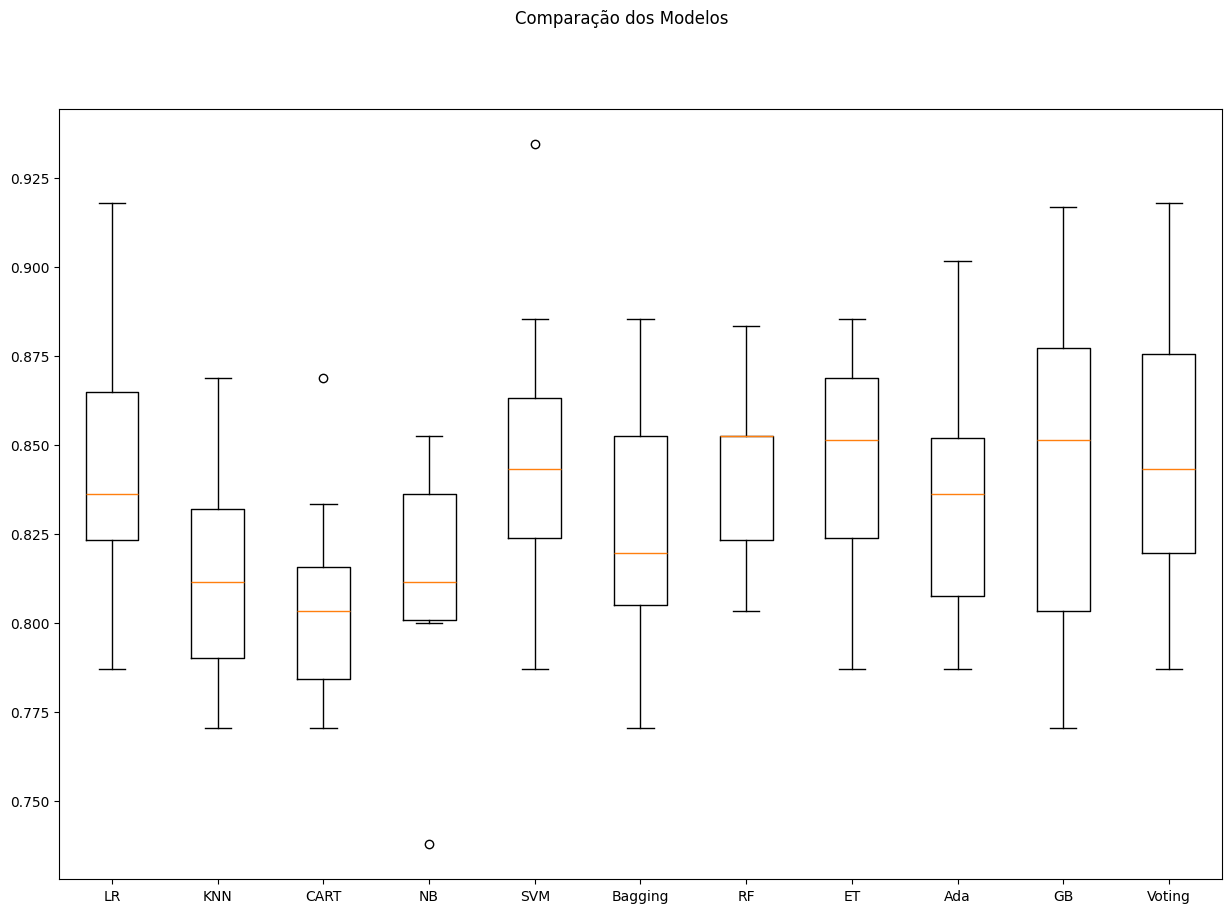

In [18]:
np.random.seed(7) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('LR', LogisticRegression(max_iter=200))) 
models.append(('KNN', KNeighborsClassifier())) 
models.append(('CART', DecisionTreeClassifier())) 
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Definindo os parâmetros do classificador base para o BaggingClassifier
base = DecisionTreeClassifier()
num_trees = 100
max_features = 3

# Criando os modelos para o VotingClassifier
bases = []
model1 = LogisticRegression(max_iter=200)
bases.append(('logistic', model1))
model2 = DecisionTreeClassifier()
bases.append(('cart', model2))
model3 = SVC()
bases.append(('svm', model3))

# Criando os ensembles e adicionando-os na lista de modelos
models.append(('Bagging', BaggingClassifier(estimator=base, n_estimators=num_trees)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('Ada', AdaBoostClassifier(n_estimators=num_trees)))
models.append(('GB', GradientBoostingClassifier(n_estimators=num_trees)))
models.append(('Voting', VotingClassifier(bases)))

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos (treinamento)
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10)) 
fig.suptitle('Comparação dos Modelos') 
ax = fig.add_subplot(111) 
plt.boxplot(results) 
ax.set_xticklabels(names) 
plt.show()

### Criação e avaliação de modelos: dados padronizados e normalizados

Trabalhando com dados pontencialmente desbalanceados ou sensíveis a escala

StandardScaler (padronização do conjunto de dados) e MinMaxScaler (normalização do conjunto de dados) são duas técnicas de normalização/escala usadas em machine learning para pré-processamento de dados e são úteis para preparar dados para algoritmos de aprendizado de máquina que são sensíveis à escala dos dados.

##### StandardScaler
StandardScaler padroniza os dados, ou seja, remove a média e escala os dados para que tenham uma variância unitária. Ele transforma os dados para que a média de cada feature seja 0 e a variância seja 1.

Fórmula: $z_i=\frac{x_i-\mu}{\sigma}$

 
onde:
- $x_i$ é o valor original do $i$-ésimo termo da feature.
- $\mu$ é a média dos valores da feature.
- $\sigma$ é o desvio padrão dos valores da feature.
𝑥
x é o valor original da feature.
𝜇
μ é a média dos valores da feature.
𝜎
σ é o desvio padrão dos valores da feature.


##### MinMaxScaler
MinMaxScaler escala e transforma os dados para um intervalo específico, geralmente entre 0 e 1. Ele transforma os dados para que o menor valor de uma feature seja 0 e o maior valor seja 1.

Fórmula: $z_i=\frac{x_i-min(x)}{max(x)-min(x)}$

onde:
- $x_i$ é o valor original do $i$-ésimo termo da feature.
- $min(x)$ é o menor valor da feature.
- $max(x)$ é o maior valor da feature.

Nós vamos aplicar essas técnicas para os dados do dataset de diabetes através da construção de pipelines. Pipelines são uma maneira de simplificar o processo de construção de modelos, permitindo que você execute várias etapas de pré-processamento e modelagem em sequência.

LR-orig: 0.845 (0.035)
KNN-orig: 0.814 (0.029)
CART-orig: 0.804 (0.029)
NB-orig: 0.812 (0.031)
SVM-orig: 0.849 (0.039)
Bag-orig: 0.829 (0.037)
RF-orig: 0.841 (0.024)
ET-orig: 0.845 (0.032)
Ada-orig: 0.834 (0.032)
GB-orig: 0.842 (0.044)
Vot-orig: 0.847 (0.037)
LR-padr: 0.844 (0.039)
KNN-padr: 0.813 (0.034)
CART-padr: 0.803 (0.029)
NB-padr: 0.812 (0.031)
SVM-padr: 0.849 (0.039)
Bag-padr: 0.826 (0.033)
RF-padr: 0.840 (0.031)
ET-padr: 0.844 (0.030)
Ada-padr: 0.834 (0.032)
GB-padr: 0.842 (0.044)
Vot-padr: 0.845 (0.037)
LR-norm: 0.845 (0.035)
KNN-norm: 0.821 (0.028)
CART-norm: 0.798 (0.024)
NB-norm: 0.812 (0.031)
SVM-norm: 0.847 (0.034)
Bag-norm: 0.831 (0.029)
RF-norm: 0.834 (0.023)
ET-norm: 0.844 (0.030)
Ada-norm: 0.834 (0.032)
GB-norm: 0.842 (0.044)
Vot-norm: 0.845 (0.037)


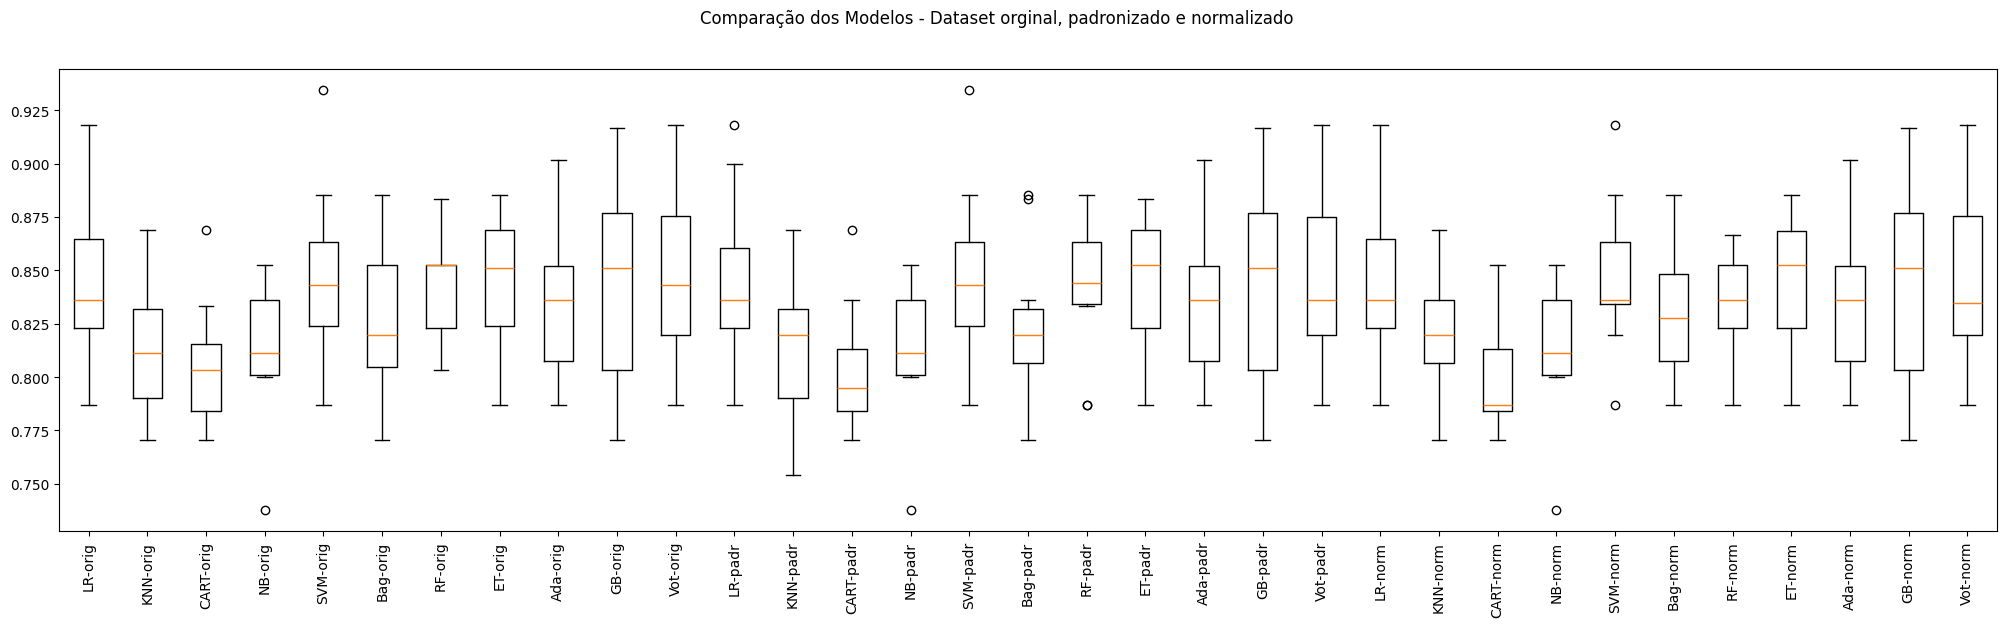

In [19]:
np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []


# Criando os elementos do pipeline

# Algoritmos que serão utilizados
reg_log = ('LR', LogisticRegression(max_iter=200))
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())
bagging = ('Bag', BaggingClassifier(estimator=base, n_estimators=num_trees))
random_forest = ('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features))
extra_trees = ('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features))
adaboost = ('Ada', AdaBoostClassifier(n_estimators=num_trees))
gradient_boosting = ('GB', GradientBoostingClassifier(n_estimators=num_trees))
voting = ('Voting', VotingClassifier(bases))

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


# Montando os pipelines
# A ordem de execução é da esquerda para a direita.

# Dataset original
pipelines.append(('LR-orig', Pipeline([reg_log]))) 
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))
pipelines.append(('Bag-orig', Pipeline([bagging])))
pipelines.append(('RF-orig', Pipeline([random_forest])))
pipelines.append(('ET-orig', Pipeline([extra_trees])))
pipelines.append(('Ada-orig', Pipeline([adaboost])))
pipelines.append(('GB-orig', Pipeline([gradient_boosting])))
pipelines.append(('Vot-orig', Pipeline([voting])))

# Dataset Padronizado
pipelines.append(('LR-padr', Pipeline([standard_scaler, reg_log]))) 
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))
pipelines.append(('Bag-padr', Pipeline([standard_scaler, bagging]))) 
pipelines.append(('RF-padr', Pipeline([standard_scaler, random_forest])))
pipelines.append(('ET-padr', Pipeline([standard_scaler, extra_trees])))
pipelines.append(('Ada-padr', Pipeline([standard_scaler, adaboost])))
pipelines.append(('GB-padr', Pipeline([standard_scaler, gradient_boosting])))
pipelines.append(('Vot-padr', Pipeline([standard_scaler, voting])))

# Dataset Normalizado
pipelines.append(('LR-norm', Pipeline([min_max_scaler, reg_log]))) 
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))
pipelines.append(('Bag-norm', Pipeline([min_max_scaler, bagging]))) 
pipelines.append(('RF-norm', Pipeline([min_max_scaler, random_forest])))
pipelines.append(('ET-norm', Pipeline([min_max_scaler, extra_trees])))
pipelines.append(('Ada-norm', Pipeline([min_max_scaler, adaboost])))
pipelines.append(('GB-norm', Pipeline([min_max_scaler, gradient_boosting])))
pipelines.append(('Vot-norm', Pipeline([min_max_scaler, voting])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado') 
ax = fig.add_subplot(111) 
plt.boxplot(results) 
ax.set_xticklabels(names, rotation=90)
plt.show()

### Otimização dos hiperparâmetros

A otimização de hiperparâmetros é o processo de encontrar os valores ideais para os hiperparâmetros de um modelo de machine learning. O objetivo é encontrar a combinação de hiperparâmetros que resulta no melhor desempenho do modelo.


##### Grid Search (*força bruta*)

Como Funciona o Grid Search?
1. Definição do Espaço de Hiperparâmetros: Primeiro, define-se um conjunto de valores possíveis para cada hiperparâmetro.
2. Avaliação das Combinações: Em seguida, cada combinação possível desses valores é avaliada.
3. Seleção do Melhor Conjunto: A combinação de hiperparâmetros que produz o melhor desempenho é selecionada.

In [20]:
np.random.seed(7)  # Definindo uma semente global para este bloco

# Lista de modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('LR', LogisticRegression(max_iter=200))) 
models.append(('KNN', KNeighborsClassifier())) 
models.append(('CART', DecisionTreeClassifier())) 
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Definindo os parâmetros do classificador base para o BaggingClassifier
base = DecisionTreeClassifier()
num_trees = 100
max_features = 3

# Criando os modelos para o VotingClassifier
bases = []
model1 = LogisticRegression(max_iter=200)
bases.append(('logistic', model1))
model2 = DecisionTreeClassifier()
bases.append(('cart', model2))
model3 = SVC()
bases.append(('svm', model3))

# Criando os ensembles e adicionando-os na lista de modelos
models.append(('Bagging', BaggingClassifier(estimator=base, n_estimators=num_trees)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('Ada', AdaBoostClassifier(n_estimators=num_trees)))
models.append(('GB', GradientBoostingClassifier(n_estimators=num_trees)))
models.append(('Voting', VotingClassifier(estimators=bases, voting='hard')))

# Definindo os componentes do pipeline
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

# Lista de pipelines
pipelines = []

# Criando pipelines para cada modelo
for name, model in models:
    pipelines.append((name + '-orig', Pipeline(steps=[(name, model)])))
    pipelines.append((name + '-padr', Pipeline(steps=[standard_scaler, (name, model)])))
    pipelines.append((name + '-norm', Pipeline(steps=[min_max_scaler, (name, model)])))

# Definindo os parâmetros para GridSearchCV
param_grids = {
    'LR': {
        'LR__C': [0.01, 0.1, 1, 10, 100],
        'LR__solver': ['liblinear', 'saga']
    },
    'KNN': {
        'KNN__n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
        'KNN__metric': ["euclidean", "manhattan", "minkowski"]
    },
    'CART': {
        'CART__max_depth': [None, 10, 20, 30, 40, 50],
        'CART__min_samples_split': [2, 5, 10],
        'CART__min_samples_leaf': [1, 2, 4]
    },
    'NB': {
        'NB__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
    },
    'SVM': {
        'SVM__C': [0.1, 1, 10, 100],
        'SVM__gamma': [1, 0.1, 0.01, 0.001],
        'SVM__kernel': ['rbf', 'linear']
    },
    'RF': {
        'RF__n_estimators': [10, 50, 100, 200],
        'RF__max_features': ['auto', 'sqrt', 'log2'],
        'RF__max_depth': [None, 10, 20, 30],
        'RF__min_samples_split': [2, 5, 10],
        'RF__min_samples_leaf': [1, 2, 4]
    },
    'ET': {
        'ET__n_estimators': [10, 50, 100, 200],
        'ET__max_features': ['auto', 'sqrt', 'log2'],
        'ET__max_depth': [None, 10, 20, 30],
        'ET__min_samples_split': [2, 5, 10],
        'ET__min_samples_leaf': [1, 2, 4]
    },
    'Ada': {
        'Ada__n_estimators': [10, 50, 100, 200],
        'Ada__learning_rate': [0.01, 0.1, 1, 10]
    },
    'GB': {
        'GB__n_estimators': [10, 50, 100, 200],
        'GB__learning_rate': [0.01, 0.1, 0.2, 0.3],
        'GB__max_depth': [3, 5, 7, 9]
    },
    'Voting': {
        # Para VotingClassifier, geralmente não há hiperparâmetros para ajustar diretamente
        # Ajustar os hiperparâmetros dos estimadores base individualmente se necessário
    }
}

# Parâmetros de cross-validation e scoring
scoring = 'accuracy'
kfold = 5

# Executando o GridSearchCV para cada pipeline
for name, pipeline in pipelines:
    model_type = name.split('-')[0]
    if model_type in param_grids:
        param_grid = param_grids[model_type]
    else:
        param_grid = {}  # Para modelos que não têm parâmetros definidos

    grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # Imprimindo a melhor configuração
    print("Modelo: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))
    
#It took 53min


Modelo: LR-orig - Melhor: 0.851958 usando {'LR__C': 0.1, 'LR__solver': 'saga'}
Modelo: LR-padr - Melhor: 0.847067 usando {'LR__C': 0.01, 'LR__solver': 'saga'}
Modelo: LR-norm - Melhor: 0.851958 usando {'LR__C': 0.1, 'LR__solver': 'saga'}
Modelo: KNN-orig - Melhor: 0.832231 usando {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 17}
Modelo: KNN-padr - Melhor: 0.830551 usando {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 17}
Modelo: KNN-norm - Melhor: 0.842108 usando {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 13}
Modelo: CART-orig - Melhor: 0.828953 usando {'CART__max_depth': 40, 'CART__min_samples_leaf': 1, 'CART__min_samples_split': 2}
Modelo: CART-padr - Melhor: 0.830592 usando {'CART__max_depth': 30, 'CART__min_samples_leaf': 1, 'CART__min_samples_split': 2}
Modelo: CART-norm - Melhor: 0.830551 usando {'CART__max_depth': None, 'CART__min_samples_leaf': 1, 'CART__min_samples_split': 5}
Modelo: NB-orig - Melhor: 0.805934 usando {'NB__var_smoothing': 1e-09}
Modelo: NB-padr - Me

In [21]:
# Modelo: LR-orig - Melhor: 0.851958 usando {'LR__C': 0.1, 'LR__solver': 'saga'}
# Modelo: LR-padr - Melhor: 0.847067 usando {'LR__C': 0.01, 'LR__solver': 'saga'}
# Modelo: LR-norm - Melhor: 0.851958 usando {'LR__C': 0.1, 'LR__solver': 'saga'}
# Modelo: KNN-orig - Melhor: 0.832231 usando {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 17}
# Modelo: KNN-padr - Melhor: 0.830551 usando {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 17}
# Modelo: KNN-norm - Melhor: 0.842108 usando {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 13}
# Modelo: CART-orig - Melhor: 0.828953 usando {'CART__max_depth': 40, 'CART__min_samples_leaf': 1, 'CART__min_samples_split': 2}
# Modelo: CART-padr - Melhor: 0.830592 usando {'CART__max_depth': 30, 'CART__min_samples_leaf': 1, 'CART__min_samples_split': 2}
# Modelo: CART-norm - Melhor: 0.830551 usando {'CART__max_depth': None, 'CART__min_samples_leaf': 1, 'CART__min_samples_split': 5}
# Modelo: NB-orig - Melhor: 0.805934 usando {'NB__var_smoothing': 1e-09}
# Modelo: NB-padr - Melhor: 0.805934 usando {'NB__var_smoothing': 1e-09}
# Modelo: NB-norm - Melhor: 0.805934 usando {'NB__var_smoothing': 1e-09}
# Modelo: SVM-orig - Melhor: 0.850305 usando {'SVM__C': 10, 'SVM__gamma': 1, 'SVM__kernel': 'rbf'}
# Modelo: SVM-padr - Melhor: 0.847040 usando {'SVM__C': 1, 'SVM__gamma': 1, 'SVM__kernel': 'rbf'}
# Modelo: SVM-norm - Melhor: 0.847013 usando {'SVM__C': 1, 'SVM__gamma': 1, 'SVM__kernel': 'rbf'}
# Modelo: Bagging-orig - Melhor: 0.832191 usando {}
# Modelo: Bagging-padr - Melhor: 0.838789 usando {}
# Modelo: Bagging-norm - Melhor: 0.837149 usando {}
# Modelo: RF-orig - Melhor: 0.865086 usando {'RF__max_depth': 10, 'RF__max_features': 'log2', 'RF__min_samples_leaf': 2, 'RF__min_samples_split': 5, 'RF__n_estimators': 10}
# Modelo: RF-padr - Melhor: 0.860154 usando {'RF__max_depth': 30, 'RF__max_features': 'sqrt', 'RF__min_samples_leaf': 4, 'RF__min_samples_split': 5, 'RF__n_estimators': 10}
# Modelo: RF-norm - Melhor: 0.856876 usando {'RF__max_depth': None, 'RF__max_features': 'sqrt', 'RF__min_samples_leaf': 4, 'RF__min_samples_split': 2, 'RF__n_estimators': 100}
# Modelo: ET-orig - Melhor: 0.856862 usando {'ET__max_depth': 10, 'ET__max_features': 'sqrt', 'ET__min_samples_leaf': 1, 'ET__min_samples_split': 5, 'ET__n_estimators': 10}
# Modelo: ET-padr - Melhor: 0.858542 usando {'ET__max_depth': None, 'ET__max_features': 'log2', 'ET__min_samples_leaf': 4, 'ET__min_samples_split': 2, 'ET__n_estimators': 10}
# Modelo: ET-norm - Melhor: 0.860127 usando {'ET__max_depth': 20, 'ET__max_features': 'log2', 'ET__min_samples_leaf': 4, 'ET__min_samples_split': 2, 'ET__n_estimators': 10}
# Modelo: Ada-orig - Melhor: 0.845360 usando {'Ada__learning_rate': 0.1, 'Ada__n_estimators': 100}
# Modelo: Ada-padr - Melhor: 0.845360 usando {'Ada__learning_rate': 0.1, 'Ada__n_estimators': 100}
# Modelo: Ada-norm - Melhor: 0.845360 usando {'Ada__learning_rate': 0.1, 'Ada__n_estimators': 100}
# Modelo: GB-orig - Melhor: 0.848611 usando {'GB__learning_rate': 0.3, 'GB__max_depth': 3, 'GB__n_estimators': 10}
# Modelo: GB-padr - Melhor: 0.848611 usando {'GB__learning_rate': 0.3, 'GB__max_depth': 3, 'GB__n_estimators': 10}
# Modelo: GB-norm - Melhor: 0.848611 usando {'GB__learning_rate': 0.3, 'GB__max_depth': 3, 'GB__n_estimators': 10}
# Modelo: Voting-orig - Melhor: 0.845387 usando {}
# Modelo: Voting-padr - Melhor: 0.838789 usando {}
# Modelo: Voting-norm - Melhor: 0.842081 usando {}

In [22]:
# Tuning do RF

np.random.seed(7)  # Definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
rf = ('RF', RandomForestClassifier())  # Usando RandomForestClassifier
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

# Criando os pipelines com Random Forest
pipelines.append(('RF-orig', Pipeline(steps=[rf])))
pipelines.append(('RF-padr', Pipeline(steps=[standard_scaler, rf])))
pipelines.append(('RF-norm', Pipeline(steps=[min_max_scaler, rf])))

# Definindo o param_grid com os melhores hiperparâmetros
param_grid = {
    'RF__n_estimators': [10],  # Melhor valor encontrado
    'RF__max_depth': [10],  # Melhor valor encontrado
    'RF__max_features': ['log2'],  # Melhor valor encontrado
    'RF__min_samples_split': [5],  # Melhor valor encontrado
    'RF__min_samples_leaf': [2],  # Melhor valor encontrado
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # Imprime a melhor configuração
    print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Sem tratamento de missings: RF-orig - Melhor: 0.845306 usando {'RF__max_depth': 10, 'RF__max_features': 'log2', 'RF__min_samples_leaf': 2, 'RF__min_samples_split': 5, 'RF__n_estimators': 10}
Sem tratamento de missings: RF-padr - Melhor: 0.837136 usando {'RF__max_depth': 10, 'RF__max_features': 'log2', 'RF__min_samples_leaf': 2, 'RF__min_samples_split': 5, 'RF__n_estimators': 10}
Sem tratamento de missings: RF-norm - Melhor: 0.842067 usando {'RF__max_depth': 10, 'RF__max_features': 'log2', 'RF__min_samples_leaf': 2, 'RF__min_samples_split': 5, 'RF__n_estimators': 10}


## Finalização do Modelo

In [23]:
# Avaliação do modelo com o conjunto de testes
# Melhor modelo
# Modelo: RF-orig - Melhor: 0.845306 usando {'RF__max_depth': 10, 'RF__max_features': 'log2', 'RF__min_samples_leaf': 2, 'RF__min_samples_split': 5, 'RF__n_estimators': 10}

np.random.seed(7)

# Preparação do modelo
scaler = MinMaxScaler().fit(X_train)
rescaledX = scaler.transform(X_train) # aplicação da normalização no conjunto de treino
model = RandomForestClassifier(n_estimators=10, 
                               max_features='log2',
                               min_samples_split=5,
                               max_depth=10,
                               min_samples_leaf=2)
model.fit(rescaledX, y_train)

# Estimativa da acurácia no conjunto de teste
rescaledTestX = scaler.transform(X_test) # aplicação da normalização no conjunto de teste
predictions = model.predict(rescaledTestX)
print(accuracy_score(y_test, predictions))

0.868421052631579


Rodando o modelo a partir de um pipeline com os hiperparâmetros otimizados.

In [24]:
np.random.seed(7)

model = RandomForestClassifier(n_estimators=10, 
                               max_features='log2',
                               min_samples_split=5,
                               max_depth=10,
                               min_samples_leaf=2)

pipeline = Pipeline(steps=[('MinMaxScaler', MinMaxScaler()), ('RF', model)])

pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
print(accuracy_score(y_test, predictions))

0.868421052631579


## Salvando os arquivos

In [25]:
# Salvando o modelo
model_filename = 'rf_tea_classifier.pkl'
with open("../models/"+model_filename, 'wb') as file:
    pickle.dump(model, file)

# Salvando o scaler
scaler_filename = 'minmax_scaler_tea.pkl'
with open("../scalers/"+scaler_filename, 'wb') as file:
    pickle.dump(scaler, file)
    
# Salvando o pipeline
pipeline_filename = 'rf_tea_pipeline.pkl'
with open("../pipelines/"+pipeline_filename, 'wb') as file:
    pickle.dump(pipeline, file)
    
# Salvando X_test e y_test
X_test_df = pd.DataFrame(X_test, columns=dataset.columns[:-1])
y_test_df = pd.DataFrame(y_test, columns=[dataset.columns[-1]])
X_test_df.to_csv("../data/X_test_dataset_tea.csv", index=False)
y_test_df.to_csv("../data/y_test_dataset_tea.csv", index=False)


In [26]:
# Gerando o arquivo CSV para o Pytest
dataset.to_csv('../data/test_dataset_tea.csv', index=False)
print("Arquivo CSV gerado com sucesso!")

Arquivo CSV gerado com sucesso!


## Simulando a aplicação do modelo em dados não vistos

In [27]:
# Preparação do modelo com TODO o dataset
scaler = MinMaxScaler().fit(X) # ajuste do scaler com TODO o dataset
rescaledX = scaler.transform(X) # aplicação da normalização com TODO o dataset
model.fit(rescaledX, y)

RandomForestClassifier(max_depth=10, max_features='log2', min_samples_leaf=2,
                       min_samples_split=5, n_estimators=10)

In [28]:
# Novos dados - não sabemos a classe!
data = {'a1_score': [0],
        'a2_score': [0],
        'a3_score': [1],
        'a4_score': [1],
        'a5_score': [1],
        'a6_score': [1],
        'a7_score': [1],
        'a8_score': [1],
        'a9_score': [1],
        'a10_score': [0],
        'gender_cod': [0],
        'jaundice_cod': [0],
        'autism_cod': [0],
        'relation_cod': [0]
        }

atributos = ['a1_score', 'a2_score', 'a3_score', 'a4_score', 'a5_score', 'a6_score', 'a7_score', 'a8_score', 'a9_score', 'a10_score', 'gender_cod', 'jaundice_cod', 'autism_cod', 'relation_cod']
entrada = pd.DataFrame(data, columns=atributos)

array_entrada = entrada.values
X_entrada = array_entrada[:,0:14].astype(int)

# Padronização nos dados de entrada usando o scaler utilizado em X
rescaledEntradaX = scaler.transform(X_entrada)
print(rescaledEntradaX)

[[0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]]


In [29]:
# Predição de classes dos dados de entrada
saidas = model.predict(rescaledEntradaX)
print(saidas)

[1]


## Conclusões sobre o modelo
- Foi utlizando um dataset relacionado ao Autismo em função do meu projeto Full Stack ser relacionado a Autismo.
- O Dataset precisou ser tratado, isso com informações obtidas de neuropsicólogos, pessoas mais experientes em Machine Learning.
- O Dataset também apresentou alguns valores em alguns campos, sem explicitar o que significava, por isso, foram removidos, até mesmo por não serem essenciais.
- Nos testes iniciais, foram identificados que os algoritmos LR e ET foram os melhores, mesmo com dados padronizados e normalizados.
- Embora o LR e ET tenham tido melhores resultados iniciais, o RF-orig, se saiu melhor após o uso do Grid Search, por este motivo, foi o algoritmo escolhido.
- Ao fazer o tuning do RF-orig, não se percebeu melhores resultados, mas segui com o RF-orig.
- Nos arquivos salvos, foi adicionado um arquivo para ser utilizado nos testes unitários.
- Ao se testar o modelo, percebeu-se que o A1_Score até A10_Score, influenciam bastante nos resultados e podendo ter pesos diferentes, dos quais não identifiquei uma lógica de peso.